In [1]:
import os

import pandas as pd
import numpy as np
from itertools import combinations

from numpy.core.defchararray import capitalize
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.stats.power import normal_sample_size_one_tail
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from ete3 import Tree

In [2]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
div_time = {'mr': 13.10, 'cs': 24.60,'hr': 28.82, 'cd': 55.4, 'csp': 61.8,'cspcd': 76.0,'mrr': 79.0,  'hrmrr': 87.2, 'hrmrrcspcd': 94.0, 'hrmrrcspcdc': 318.9, 'hrmrrcspcdcz': 429.0}

alignment_code_to_species_legend = {
    'mr': 'Mouse/Rat',
    'cs': 'Cow/Sheep',
    'hr': 'Human/Rhesus',
    'cd': 'Cat/Dog',
    'csp': 'Pig/Cow/Sheep',
    'cspcd': 'Pig/Cow/Sheep/Dog/Cat',
    'mrr': 'Mouse/Rabbit/Rat',
    'hrmrr': 'Human/Mouse/Rhesus/Rabbit/Rat',
    'hrmrrcspcd': 'Mammals',
    'hrmrrcspcdc': 'Mammals/Chicken',
    'hrmrrcspcdcz': 'Mammals/Chicken/Zebrafish'
}
species_mapping = {'hr':'primates','mr':'rodents','cs':'cattle','cd':'carnivores','csp':'ungulates','cspcd':'laurasians','mrr':'glires','hrmrr':'eurarchontoglires','hrmrrcspcd':'mammals','hrmrrcspcdc':'tetrapods',"hrmrrcspcdcz":"vertebrates"}


In [4]:
def get_code_conversion(code):
    alignment_code_to_species = {'hr':          'human;rhesus',
                                 'mr':          'mouse;rat',
                                 'cd':          'cat;dog',
                                 'cs':          'cow;sheep',
                                 'csp':         'pig;cow;sheep',
                                 'mrr':         'mouse;rabbit;rat',
                                 'cspcd':       'pig;cow;sheep;dog;cat',
                                 'hrmrr':       'human;mouse;rhesus;rabbit;rat',
                                 'hrmrrcspcd':  'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat',
                                 'hrmrrcspcdc': 'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken',
                                 'hrmrrcspcdcz':'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken;zfish'}
    return alignment_code_to_species.get(code)

In [5]:
colors = {'rodents': "#033270",
          'cattle': "#1368AA",
          'primates': "#4091C9",
          'carnivores': "#4AA8CD",
          'ungulates': "#BA746B",
          'laurasians': "#F29479",
          'glires': "#F26A4F",
          'eurarchontoglires': "#EF3C2D",
          'mammals': "#CB1B16",
          'tetrapods': "#980E11",
          'vertebrates': "#65010C"
          }

colors_sorted = {i:colors[i] for i in colors.keys() }

In [6]:
def get_sb_len(species,aln,path="/Users/fabianpa/Desktop/new_sequences/synteny_3/synteny_bed"):
    sb_dfs = []
    for common_name in species:
        fname = os.path.join(path,common_name+"_"+aln+".bed")
        sb_df = pd.read_table(fname, names=("chr", "start", "stop", "aln", "strand"),header=None)
        sb_df["species"] = common_name
        sb_df["sb_length"]  = sb_df["stop"]- sb_df["start"]
        sb_dfs.append(sb_df)
    return pd.concat(sb_dfs, axis=0)

def get_tad_in_sb(species, aln,sb_coord,sb_specific_aln=None,shuffle=False,coord_path="/Users/fabianpa/Desktop/new_sequences/sb_in_tad_3/"):
    count_df = []
    coord_df = []
    for common_name in species:
        coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb")
        # coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb.bed")
        specie_aln_name = common_name.lower()+"_"+aln
        try:
            sb_tad_coord = pd.read_csv(coord_fname,sep="\t",usecols=[5,6,7,3,4], names=("aln", "strand", "chr", "start", "stop"),header=None)[["chr", "start", "stop", "aln", "strand"]]
            sb_tad_coord["species"] = common_name
            sb_tad_coord["tad_size"] = sb_tad_coord["stop"] - sb_tad_coord["start"]
            if sb_specific_aln :  coord_df.append(sb_tad_coord[sb_tad_coord.aln.isin(sb_specific_aln[specie_aln_name])])
            else: coord_df.append(sb_tad_coord)
            count_list = []
            for i in sb_coord.aln.unique():
                count = len(sb_tad_coord[(sb_tad_coord.aln==i)])
                count_list.append([i,count,common_name])

            if sb_specific_aln :
                df = pd.DataFrame(count_list, columns=['aln', 'count',"species"])
                if shuffle:df["count"] = df["count"].sample(frac=1).values
                count_df.append(df[df["aln"].isin(sb_specific_aln[specie_aln_name])])
            else: count_df.append(pd.DataFrame(count_list, columns=['aln', 'count',"species"]))

        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {e.filename}")
    return count_df, coord_df

In [7]:
def get_equal_tad_count_syn_blocks(tad_count, species):
    """
    Get syntenic blocks with equal TAD counts.

    This function takes a DataFrame of TAD counts and retrieves the syntenic blocks that have equal TAD counts
    between the two specified species.

    Parameters
    ----------
    tad_count : pandas.DataFrame containing TAD counts.
    species: list of species names.

    Returns
    -------
    list
        List of syntenic blocks with equal TAD counts.

    Notes
    -----
    The TAD counts DataFrame should have columns "species", "aln", and "count" containing species name, alignment
    identifier, and TAD count respectively.
    """

    s1_count = tad_count.loc[(tad_count.species == species[0])]
    s2_count = tad_count.loc[(tad_count.species == species[1])]
    count_diff = s1_count["count"] - s2_count["count"]
    count_diff_df = pd.DataFrame({"aln": s1_count.aln, "count_s1": s1_count["count"],
                                  "count_s2":s2_count["count"], "count_diff": count_diff})
    return count_diff_df.loc[(count_diff_df["count_diff"] == 0) & (count_diff_df["count_s1"] != 0), "aln"].values.tolist()

def map_tad_boundaries(comb_df, syn_block, species):
    filtered_tad_coord = comb_df[
            (comb_df["aln"].isin(syn_block)) &
            (comb_df["species"].isin(species))
        ].copy()

    aln_to_remove = [i for i in syn_block if (len(comb_df.loc[(comb_df["aln"] == i) &(comb_df["species"].isin(species)) & (comb_df.chr!="chrY"),"aln"]) <3) | comb_df.loc[(comb_df["aln"] == i) &(comb_df["species"].isin(species)) &(comb_df.chr!="chrY"),"aln"].empty]

    filtered_tad_coord = filtered_tad_coord[~filtered_tad_coord['aln'].isin(aln_to_remove)]

    tad_s1 = filtered_tad_coord.loc[ (filtered_tad_coord.species == species[0]),["start", "stop","aln"]]
    tad_s2 = filtered_tad_coord.loc[ (filtered_tad_coord.species == species[1]),["start", "stop","aln"]]

    scaler = MinMaxScaler(feature_range=(0, 1))
    sb = tad_s1['aln'].unique()
    s1_map = [
        np.unique(
            scaler.fit_transform(
                tad_s1.loc[tad_s1['aln'] == block, ['start', 'stop']]
                .sort_values(by='start')
                .values.flatten().reshape(-1, 1)
            )
        )[1:-1].tolist()
        for block in sb
        if len(tad_s1.loc[tad_s1['aln'] == block, ['start', 'stop']].sort_values(by='start')) > 1
    ]

    s2_map = [
        np.unique(
            scaler.fit_transform(
                tad_s2.loc[tad_s2['aln'] == block, ['start', 'stop']]
                .sort_values(by='start')
                .values.flatten().reshape(-1, 1)
            )
        )[1:-1].tolist()
        for block in sb
        if len(tad_s2.loc[tad_s2['aln'] == block, ['start', 'stop']].sort_values(by='start')) > 1
    ]
    x = [item for sublist in s1_map for item in sublist]
    y = [item for sublist in s2_map for item in sublist]
    res = stats.linregress(x, y)
    r2 = res.rvalue**2
    p_val=res.pvalue
    return r2,p_val,x,y


In [8]:
tad_sim_r2_all = []

pbar = tqdm(div_time.keys(), desc='Processing Alignment')

borders = {}
for aln in pbar:
    pbar.set_description(f'Processing Alignment -> {aln}')

    species = get_code_conversion(aln).split(';')

    sb_coord = get_sb_len(species,aln)
    tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)

    tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
    tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)

    comb = list(combinations(species, 2))
    size_similarity = []
    size_similarity_rdm = []
    border_similarity = []
    p_values =[]
    for i in comb:
        syn_block = get_equal_tad_count_syn_blocks(tad_sb_count_df, i)
        comb_df = (tad_sb_coord_df.loc[(tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1])])
        r2,pval,x,y= map_tad_boundaries(comb_df, syn_block,i)
        if aln =="hr":
            borders[i]=(x,y)
        border_similarity.append(r2)
        p_values.append(pval)

    test_statistic, combined_p_value =  stats.combine_pvalues(p_values, method='fisher')
    tad_sim_r2_all.append([aln, div_time[aln],np.mean(border_similarity),combined_p_value,p_values])

r2_all_df = pd.DataFrame(tad_sim_r2_all, columns=['alignment', 'mya','tad_border_similarity',"pvalue","p_val_distr"])
r2_all_df["alignment"] = r2_all_df["alignment"].replace(species_mapping)
r2_all_df

Processing Alignment -> hrmrrcspcdcz: 100%|██████████| 11/11 [00:49<00:00,  4.54s/it]


,alignment,mya,tad_border_similarity,pvalue,p_val_distr
0,rodents,13.10,0.746111,9.910208e-33,[9.910207938199036e-33]
1,cattle,24.60,0.805425,1.901925e-07,[1.9019250176144647e-07]
2,primates,28.82,0.917236,8.793254e-42,[8.79325424307569e-42]
3,carnivores,55.40,0.901306,3.566712e-122,[3.566712034969237e-122]
4,ungulates,61.80,0.799365,6.056244e-242,"[1.0797827013768068e-57, 5.963908314548524e-12..."
5,laurasians,76.00,0.737326,0.000000e+00,"[2.7616874228664323e-87, 1.623825177203499e-92..."
6,glires,79.00,0.652018,1.484472e-146,"[5.499690900629846e-39, 1.101923755852086e-79,..."
7,eurarchontoglires,87.20,0.668365,0.000000e+00,"[3.766869054734251e-38, 9.13086694675948e-152,..."
8,mammals,94.00,0.563330,0.000000e+00,"[8.794007441411307e-31, 4.439323214835477e-65,..."
9,tetrapods,318.90,0.342046,0.000000e+00,"[2.0194185118985133e-26, 1.1261972894107022e-3..."


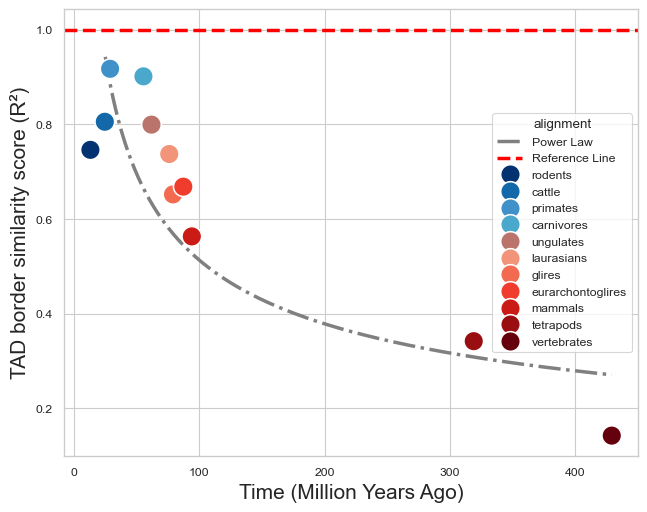

In [10]:
# plt.figure(figsize=(15, 11))
plt.figure(figsize=(7.4, 5.8))

X = r2_all_df["mya"]
Y = r2_all_df["tad_border_similarity"]

log_x = np.log(X)
log_y = np.log(Y)

coefficients = np.polyfit(log_x, log_y, 1)
b = coefficients[0]
a = np.exp(coefficients[1])

# x_values = np.linspace(X.min(), X.max(), 400)
x_values = np.linspace(25, X.max(), 400)
y_values = a * x_values ** b

plt.plot(x_values, y_values,  color='grey', linestyle="-.",label='Power Law',linewidth=2.5,zorder=1)
plt.axhline(y=1, color='r',linestyle="--",label='Reference Line',linewidth=2.5)
sns.scatterplot(data=r2_all_df, x="mya", y="tad_border_similarity", hue="alignment",palette=list(colors_sorted.values()),s=200)

plt.xlabel("Time (Million Years Ago)",fontsize=15)
plt.ylabel(f"TAD border similarity score (R\N{SUPERSCRIPT TWO})",fontsize=15)

plt.savefig("../images/figure 4/tad_border_r2_fitted.1.png", bbox_inches='tight',dpi=600)
plt.savefig("../images/figure 4/tad_border_r2_fitted.1.svg", bbox_inches='tight')
plt.show()

Illustration

In [8]:
def calc_border_similarity(mapped_tads):
    # Calculate the border similarity between species 1 and species 2
    s1,s2 = list(mapped_tads.keys())[0],list(mapped_tads.keys())[1]
    if len(mapped_tads[s1])==2: return None
    x = mapped_tads[s1]
    y = mapped_tads[s2]
    res = stats.linregress(x, y)
    r2 = res.rvalue**2
    p_val=res.pvalue
    return r2

def map_tad_boundaries_single(tad_coord, species):
    tad_coord.sort_values(by=['start'], inplace=True)
    result_similarity = []
    tad_bord = []
    for code in tad_coord.aln.unique():
        species_coord = {sp: tad_coord.loc[(tad_coord.aln == code) & (tad_coord.species == sp), ["start", "stop"]] for sp in species}

        # Map the TAD boundaries to the range [0, 1]
        scaler = MinMaxScaler(feature_range=(0, 1))
        mapped_tads = {sp: np.unique(scaler.fit_transform(coord.values.flatten().reshape(-1, 1))) for sp, coord in species_coord.items() if not coord.empty}
        tad_bord.append(mapped_tads)
        # Compute the TADs similarity
        border_similarity = calc_border_similarity(mapped_tads)

        if border_similarity is not None: result_similarity.append([code,border_similarity,species,len(mapped_tads[species[0]])])

    df_similarity = pd.DataFrame(result_similarity, columns=['Aln', 'Border Similarity','pair',"len"])
    return df_similarity,tad_bord

In [11]:
aln = "hr"
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)

tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
syn_block = "Alignment51"
tad_coord = tad_sb_coord_df.loc[tad_sb_coord_df.aln== syn_block].copy()

result,bound = map_tad_boundaries_single(tad_coord, species)

NameError: name 'borders' is not defined

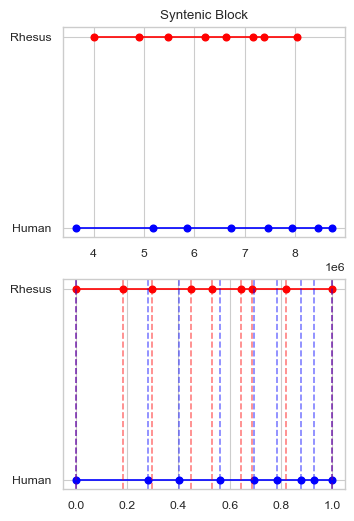

In [12]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 2])

region1_tads = tad_coord.loc[tad_coord.species =="human","start"].tolist()  # Original positions for region 1
region2_tads = tad_coord.loc[tad_coord.species =="rhesus","start"].tolist()  # Original positions for region 2

# Normalize TAD positions to the range [0,1]
region1_normalized = bound[0]["human"]
region2_normalized = bound[0]["rhesus"]

# Plot 1 (Top-left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(region1_tads, [1] * len(region1_tads), 'ro-')
ax1.plot(region2_tads, [0] * len(region2_tads), 'bo-')

ax1.set_yticks([0, 1])
ax1.set_yticklabels(["Human", "Rhesus"])
ax1.set_title("Syntenic Block")

# Plot 2 (Bottom-left)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(region1_normalized, [1] * len(region1_normalized), 'ro-')
ax2.plot(region2_normalized, [0] * len(region2_normalized), 'bo-')

for tad in region1_normalized:
    ax2.axvline(x=tad, color='r', linestyle='--', alpha=0.5)
for tad in region2_normalized:
    ax2.axvline(x=tad, color='b', linestyle='--', alpha=0.5)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["Human", "Rhesus"])

# Plot 3 (Right, spanning both rows in the second column)
x = np.array(borders[('human', 'rhesus')][0][1:])
y = np.array(borders[('human', 'rhesus')][1][1:])
correlation_matrix = np.corrcoef(x, y)
r_squared = correlation_matrix[0, 1] ** 2

ax3 = fig.add_subplot(gs[:, 1])
ax3.plot([0, 1], [0, 1], color='orange', linestyle='--', label="Ideal Correlation",linewidth=2.5,zorder=0)
ax3.scatter(borders[('human', 'rhesus')][0],borders[('human', 'rhesus')][1],label=f"R² = {r_squared:.2f}",s=30,zorder=1,alpha=0.7)
ax3.set_xlabel("Human Mapped Borders")
ax3.set_ylabel("Rhesus Mapped Borders")
ax3.set_title("TAD Borders Correlation (R²) in primates")
ax3.legend()

plt.tight_layout()
# plt.savefig("../images/figure 4/illustration_fig4.svg")
plt.show()

In [15]:
def compute_delta_single_block(comb_df, syn_block, species,tad_number=4):
    filtered_tad_coord = comb_df[
        (comb_df["aln"]==syn_block) &
        (comb_df["species"].isin(species))
        ].copy()
    tad_s1 = filtered_tad_coord.loc[(filtered_tad_coord.species == species[0]), ["start", "stop", "aln","strand"]]
    tad_s2 = filtered_tad_coord.loc[(filtered_tad_coord.species == species[1]), ["start", "stop", "aln","strand"]]

    strand_1 = tad_s1["strand"].values[0]
    strand_2 = tad_s1["strand"].values[0]
    tad_s1 = tad_s1.sort_values(by=['aln', 'start']).drop_duplicates(['aln', 'start', 'stop'])
    tad_s2 = tad_s2.sort_values(by=['aln', 'start']).drop_duplicates(['aln', 'start', 'stop'])

    # tad_s1 = tad_s1.sort_values(by=['start'], ascending=(strand_1 != "-")).reset_index(drop=True)
    # tad_s2 = tad_s2.sort_values(by=['start'], ascending=(strand_2 != "-")).reset_index(drop=True)

    if species[0] == "mouse" and species[1] =="rat":
        print(tad_s1)

    if len(tad_s1)==8:
        scaler = MinMaxScaler(feature_range=(0, 1))
        deltas = []
        block = tad_s1['aln'].unique()[0]
        # if species[0] == "mouse" and species[1] =="rat":


        block_tad_s1 = np.unique(tad_s1.loc[tad_s1['aln'] == block, ['start', 'stop']].values.flatten()).reshape(-1, 1)
        block_tad_s2 = np.unique(tad_s2.loc[tad_s2['aln'] == block, ['start', 'stop']].values.flatten()).reshape(-1, 1)

        # Scale boundaries within each block
        scaled_tad_s1 = scaler.fit_transform(block_tad_s1)
        scaled_tad_s2 = scaler.fit_transform(block_tad_s2)

        if species[0] == "mouse" and species[1] =="rat":
            if strand_1 == "-":  scaled_tad_s1 = 1 - scaled_tad_s1
            region1_normalized = [item for sublist in reversed(scaled_tad_s1) for item in sublist]
            print(scaled_tad_s1)

        else: region1_normalized = [item for sublist in scaled_tad_s1 for item in sublist]
        region2_normalized = [item for sublist in scaled_tad_s2 for item in sublist]
        plot_block(region1_normalized,region2_normalized,species[0],species[1])

        for s1, s2 in zip(scaled_tad_s1, scaled_tad_s2):
            if s1!=0 and s1!=1:
                delta = abs(s1[0] - s2[0])
                # if species[0] == "human" and species[1] =="rhesus":
                #     print(delta)
        return scaled_tad_s1,scaled_tad_s2
    else: return None,None

def plot_block(region1_normalized,region2_normalized,species1,species2):

    if species1 == "mouse" and species2 =="rat":
        fig, ax = plt.subplots(figsize=(7, 4))

        # Plot normalized TAD positions
        ax.plot(region1_normalized, [1] * len(region1_normalized), 'ro-')
        ax.plot(region2_normalized, [0] * len(region2_normalized), 'bo-')

        # Connect corresponding TAD positions with lines
        for tad_human, tad_rhesus in zip(region1_normalized, region2_normalized):
            ax.plot([tad_human, tad_rhesus], [1, 0], color='gray', linestyle='--', alpha=0.7)
            # Compute and annotate delta
            delta = abs(tad_human - tad_rhesus)
            if delta == 0:
                continue
            midpoint_x = (tad_human + tad_rhesus) / 2  # Position for delta annotation
            midpoint_y = 0.5
            ax.text(midpoint_x, midpoint_y, f"{delta:.3f}", fontsize=10, color='black', ha='center', va='center')

        # Formatting
        ax.set_yticks([0, 1])
        ax.set_yticklabels([species2.capitalize(), species1.capitalize()])
        ax.grid(axis='x', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig(plt.savefig("../images/figure 4/panel_C/mouse_rat.aln169.svg"))
        plt.show()



SIX

        start      stop           aln strand
233  84160000  84768000  Alignment169      -
238  84768000  85152000  Alignment169      -
234  85152000  85952000  Alignment169      -
239  85952000  86464000  Alignment169      -
235  86464000  86784000  Alignment169      -
240  86784000  87232000  Alignment169      -
236  87232000  87584000  Alignment169      -
237  87584000  87968000  Alignment169      -
[[1.        ]
 [0.84033613]
 [0.7394958 ]
 [0.52941176]
 [0.39495798]
 [0.31092437]
 [0.19327731]
 [0.10084034]
 [0.        ]]


AttributeError: 'NoneType' object has no attribute 'write'

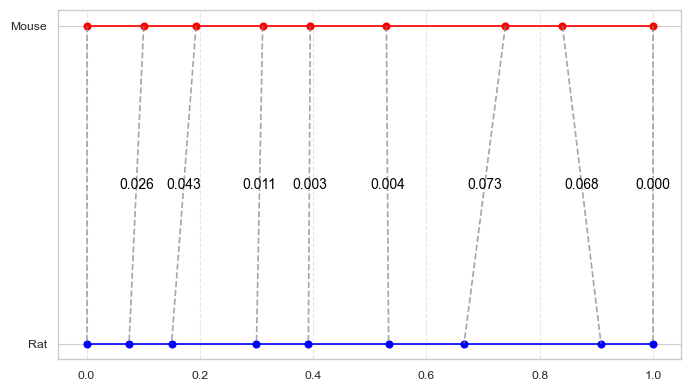

In [16]:
aln = "hrmrrcspcdc"
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)

tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
syn_block = "Alignment169"
tad_coord = tad_sb_coord_df.loc[tad_sb_coord_df.aln== syn_block].copy()

species_pairs = list(combinations(species, 2))
for species1,species2 in species_pairs:
    # print(species1,species2)
    tads = tad_sb_coord_df.loc[(tad_sb_coord_df["aln"] == syn_block) &
                                               ((tad_sb_coord_df['species'] == species1) |
                                                (tad_sb_coord_df['species'] == species2))
                                               ]
    if species1 in ["human","mouse","dog","pig","rhesus"] and species2 in ["rhesus","rat","cat","dog","mouse"] :
        bound1,bound2 = compute_delta_single_block(tads, syn_block, (species1,species2 ))
        # print(species1)
        # print(bound1)
        # print(species2)
        # print(bound2)

HOXA

In [114]:
aln = "hrmrrcspcdc"
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)

tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
syn_block = "Alignment86"
tad_coord = tad_sb_coord_df.loc[tad_sb_coord_df.aln== syn_block].copy()

species_pairs = list(combinations(species, 2))
for species1,species2 in species_pairs:
    print(species1,species2)
    tads = tad_sb_coord_df.loc[(tad_sb_coord_df["aln"] == syn_block) &
                                               ((tad_sb_coord_df['species'] == species1) |
                                                (tad_sb_coord_df['species'] == species2))
                                               ]
    compute_delta_single_block(tads, syn_block, (species1,species2 ))
    # result,bound = map_tad_boundaries_single(tad_coord, (species1, species2))
    # print(result)

human mouse
2 3
human rhesus
2 2
human rabbit
2 4
human rat
2 4
human pig
2 3
human cow
2 3
human sheep
2 2
human dog
2 3
human cat
2 3
human chicken
2 3
mouse rhesus
3 2
mouse rabbit
3 4
mouse rat
3 4
mouse pig
3 3
mouse cow
3 3
mouse sheep
3 2
mouse dog
3 3
mouse cat
3 3
mouse chicken
3 3
rhesus rabbit
2 4
rhesus rat
2 4
rhesus pig
2 3
rhesus cow
2 3
rhesus sheep
2 2
rhesus dog
2 3
rhesus cat
2 3
rhesus chicken
2 3
rabbit rat
4 4
rabbit pig
4 3
rabbit cow
4 3
rabbit sheep
4 2
rabbit dog
4 3
rabbit cat
4 3
rabbit chicken
4 3
rat pig
4 3
rat cow
4 3
rat sheep
4 2
rat dog
4 3
rat cat
4 3
rat chicken
4 3
pig cow
3 3
pig sheep
3 2
pig dog
3 3
pig cat
3 3
pig chicken
3 3
cow sheep
3 2
cow dog
3 3
cow cat
3 3
cow chicken
3 3
sheep dog
2 3
sheep cat
2 3
sheep chicken
2 3
dog cat
3 3
dog chicken
3 3
cat chicken
3 3


HOXC

In [115]:
aln = "hrmrrcspcdc"
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)

tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
syn_block = "Alignment243"
tad_coord = tad_sb_coord_df.loc[tad_sb_coord_df.aln== syn_block].copy()

species_pairs = list(combinations(species, 2))
for species1,species2 in species_pairs:
    print(species1,species2)
    tads = tad_sb_coord_df.loc[(tad_sb_coord_df["aln"] == syn_block) &
                                               ((tad_sb_coord_df['species'] == species1) |
                                                (tad_sb_coord_df['species'] == species2))
                                               ]
    compute_delta_single_block(tads, syn_block, (species1,species2 ))
    # result,bound = map_tad_boundaries_single(tad_coord, (species1, species2))
    # print(result)

human mouse
1 1
human rhesus
1 1
human rabbit
1 2
human rat
1 2
human pig
1 1
human cow
1 1
human sheep
1 2
human dog
1 0
human cat
1 1
human chicken
1 1
mouse rhesus
1 1
mouse rabbit
1 2
mouse rat
1 2
mouse pig
1 1
mouse cow
1 1
mouse sheep
1 2
mouse dog
1 0
mouse cat
1 1
mouse chicken
1 1
rhesus rabbit
1 2
rhesus rat
1 2
rhesus pig
1 1
rhesus cow
1 1
rhesus sheep
1 2
rhesus dog
1 0
rhesus cat
1 1
rhesus chicken
1 1
rabbit rat
2 2
rabbit pig
2 1
rabbit cow
2 1
rabbit sheep
2 2
rabbit dog
2 0
rabbit cat
2 1
rabbit chicken
2 1
rat pig
2 1
rat cow
2 1
rat sheep
2 2
rat dog
2 0
rat cat
2 1
rat chicken
2 1
pig cow
1 1
pig sheep
1 2
pig dog
1 0
pig cat
1 1
pig chicken
1 1
cow sheep
1 2
cow dog
1 0
cow cat
1 1
cow chicken
1 1
sheep dog
2 0
sheep cat
2 1
sheep chicken
2 1
dog cat
0 1
dog chicken
0 1
cat chicken
1 1


HOXD

In [116]:
aln = "hrmrrcspcdc"
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)

tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
syn_block = "Alignment5"
tad_coord = tad_sb_coord_df.loc[tad_sb_coord_df.aln== syn_block].copy()

species_pairs = list(combinations(species, 2))
for species1,species2 in species_pairs:
    print(species1,species2)
    tads = tad_sb_coord_df.loc[(tad_sb_coord_df["aln"] == syn_block) &
                                               ((tad_sb_coord_df['species'] == species1) |
                                                (tad_sb_coord_df['species'] == species2))
                                               ]
    compute_delta_single_block(tads, syn_block, (species1,species2 ))
    # result,bound = map_tad_boundaries_single(tad_coord, (species1, species2))
    # print(result)

human mouse
27 36
human rhesus
27 31
human rabbit
27 33
human rat
27 29
human pig
27 37
human cow
27 40
human sheep
27 31
human dog
27 29
human cat
27 28
human chicken
27 21
mouse rhesus
36 31
mouse rabbit
36 33
mouse rat
36 29
mouse pig
36 37
mouse cow
36 40
mouse sheep
36 31
mouse dog
36 29
mouse cat
36 28
mouse chicken
36 21
rhesus rabbit
31 33
rhesus rat
31 29
rhesus pig
31 37
rhesus cow
31 40
rhesus sheep
31 31
rhesus dog
31 29
rhesus cat
31 28
rhesus chicken
31 21
rabbit rat
33 29
rabbit pig
33 37
rabbit cow
33 40
rabbit sheep
33 31
rabbit dog
33 29
rabbit cat
33 28
rabbit chicken
33 21
rat pig
29 37
rat cow
29 40
rat sheep
29 31
rat dog
29 29
rat cat
29 28
rat chicken
29 21
pig cow
37 40
pig sheep
37 31
pig dog
37 29
pig cat
37 28
pig chicken
37 21
cow sheep
40 31
cow dog
40 29
cow cat
40 28
cow chicken
40 21
sheep dog
31 29
sheep cat
31 28
sheep chicken
31 21
dog cat
29 28
dog chicken
29 21
cat chicken
28 21


SIX